<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center">Elvis Chen, PhD, LEL, [chene@robarts.ca](mailto:chene@robarts.ca?subject=Day 20: Initialization)</h4>
<h4 align="center">Day 20, March 19, 2019</h4>

## Registration Initialization: We have to start somwehere

Initialization is a critical aspect of most registration algorithms, given that most algorithms are formulated as an iterative optimization problem.

In many cases we perform initialization in an automatic manner by assumptions with regard to the content of the image and the imaging protocol. For instance, if we expect that images were acquired with the patient in a known orientation we can align the geometric centres of the two volumes or the center of the mass of the image contents if the anatomy is not centered in the image.

When the orientation is now known, or is known but incorrect, this approach will not yield a reasonable initial estimate for the registration.

A heuristic, yet effective, solution is to use a sampling strategy of the parameter space. Note that this strategy is primarily useful in low dimensional parameter space (rigid or possibly affine transformations).

In this notebook we illustrate how to sample the parameter space in a fixed pattern. We then initialize the registration with the parameters that correspond to the best similarity metric value obtained by our sampling.

In [1]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing
import gui
import os
import numpy as np

from ipywidgets import interact, fixed
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

import registration_callbacks as rc
import registration_utilities as ru

# Always write output to a separate directory, we don't want to pollute the source directory. 
OUTPUT_DIR = 'Output'

%matplotlib inline

In [2]:
# This is the registration configuration which we use in all cases. The only parameter that we vary 
# is the initial_transform. 
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rc.metric_update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_plot_values(registration_method))

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

## Loading Data

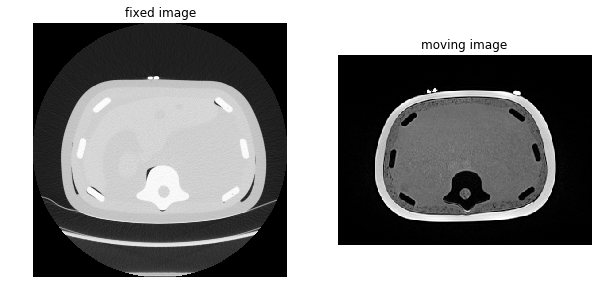

In [3]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

fixed_series_ID = "1.2.840.113619.2.290.3.3233817346.783.1399004564.515"
moving_series_ID = "1.3.12.2.1107.5.2.18.41548.30000014030519285935000000933"

reader = sitk.ImageSeriesReader()
fixed_image = sitk.ReadImage(reader.GetGDCMSeriesFileNames(data_directory, fixed_series_ID), sitk.sitkFloat32)
moving_image = sitk.ReadImage(reader.GetGDCMSeriesFileNames(data_directory, moving_series_ID), sitk.sitkFloat32)

# To provide a reasonable display we need to window/level the images. By default we could have used the intensity
# ranges found in the images [SimpleITK's StatisticsImageFilter], but these are not the best values for viewing.
# Using an external viewer we identified the following settings.
fixed_intensity_range = (-1183,544)
moving_intensity_range = (0,355)

interact(lambda image1_z, image2_z, image1, image2,:ru.display_scalar_images(image1_z, image2_z, image1, image2, 
                                                                             fixed_intensity_range,
                                                                             moving_intensity_range,
                                                                             'fixed image',
                                                                             'moving image'), 
         image1_z=(0,fixed_image.GetSize()[2]-1), 
         image2_z=(0,moving_image.GetSize()[2]-1), 
         image1 = fixed(fixed_image), 
         image2=fixed(moving_image));

Arbitrarily rotate the moving image.

In [ ]:
print(fixed_image.GetSpacing())
print(moving_image.GetSpacing())

In [ ]:
rotation_x = 0.0
rotation_z = 0.0

def modify_rotation(rx_in_degrees, rz_in_degrees):
    global rotation_x, rotation_z
    
    rotation_x = np.radians(rx_in_degrees)
    rotation_z = np.radians(rz_in_degrees)
    
interact(modify_rotation, rx_in_degrees=(0.0,180.0,5.0), rz_in_degrees=(-90.0,180.0,5.0));

In [ ]:
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(moving_image)
resample.SetInterpolator(sitk.sitkLinear)
# Rotate around the physical center of the image. 
rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in moving_image.GetSize()])
transform = sitk.Euler3DTransform(rotation_center, rotation_x, 0, rotation_z, (0,0,0))
resample.SetTransform(transform)
modified_moving_image = resample.Execute(moving_image)

interact(lambda image1_z, image2_z, image1, image2,:ru.display_scalar_images(image1_z, image2_z, image1, image2, 
                                                                             moving_intensity_range,
                                                                             moving_intensity_range, 'original', 'rotated'), 
         image1_z=(0,moving_image.GetSize()[2]-1), 
         image2_z=(0,modified_moving_image.GetSize()[2]-1), 
         image1 = fixed(moving_image), 
         image2=fixed(modified_moving_image));

## Register using standard initialization  (assumes orientation is similar)

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      modified_moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

final_transform = multires_registration(fixed_image, modified_moving_image, initial_transform)

In [ ]:
moving_resampled = sitk.Resample(modified_moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ru.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), 
         image1 = fixed(sitk.IntensityWindowing(fixed_image, fixed_intensity_range[0], fixed_intensity_range[1])), 
         image2=fixed(sitk.IntensityWindowing(moving_resampled, moving_intensity_range[0], moving_intensity_range[1])));

## Register using heuristic initialization approach (using multiple orientations)


As we want to account for significant orientation differences due to erroneous patient position (HFS...) we evaluate the similarity measure at locations corresponding to the various orientation differences. This can be done in two ways which will be illustrated below:
<ul>
<li>Use the ImageRegistrationMethod.MetricEvaluate() method.</li>
<li>Use the Exhaustive optimizer.
</ul>

The former approach is more computationally intensive as it constructs and configures a metric object each time it is invoked. It is therefore more appropriate for use if the set of parameter values we want to evaluate are not on a rectilinear grid in the parameter space. The latter approach is appropriate if the set of parameter values are on a rectilinear grid, in which case the approach is more computationally efficient.

In both cases we use the CenteredTransformInitializer to obtain the initial translation.

### MetricEvaluate

To use the MetricEvaluate method we create a ImageRegistrationMethod, set its metric and interpolator. We then iterate over all parameter settings, set the initial transform and evaluate the metric. The minimal similarity measure value corresponds to the best parameter settings.

In [ ]:
# Dictionary with all the orientations we will try. We omit the identity (x=0, y=0, z=0) as we always use it. This
# set of rotations is arbitrary. For a complete grid coverage we would naively have 64 entries 
# (0, pi/2, pi, 1.5pi for each angle), but we know better, there are only 24 unique rotation matrices defined by
# these parameter value combinations.
all_orientations = {'x=0, y=0, z=90': (0.0,0.0,np.pi/2.0),
                    'x=0, y=0, z=-90': (0.0,0.0,-np.pi),
                    'x=0, y=0, z=180': (0.0,0.0,np.pi),
                    'x=180, y=0, z=0': (np.pi,0.0,0.0),
                    'x=180, y=0, z=90': (np.pi,0.0,np.pi/2.0),
                    'x=180, y=0, z=-90': (np.pi,0.0,-np.pi/2.0),
                    'x=180, y=0, z=180': (np.pi,0.0,np.pi)}    

# Registration framework setup.
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

# Evaluate the similarity metric using the eight possible orientations, translation remains the same for all.
initial_transform = sitk.Euler3DTransform(sitk.CenteredTransformInitializer(fixed_image, 
                                                                            modified_moving_image, 
                                                                            sitk.Euler3DTransform(), 
                                                                            sitk.CenteredTransformInitializerFilter.GEOMETRY))
registration_method.SetInitialTransform(initial_transform, inPlace=False)
best_orientation = (0.0,0.0,0.0)
best_similarity_value = registration_method.MetricEvaluate(fixed_image, modified_moving_image)

# Iterate over all other rotation parameter settings. 
for key, orientation in all_orientations.items():
    initial_transform.SetRotation(*orientation)
    registration_method.SetInitialTransform(initial_transform)
    current_similarity_value = registration_method.MetricEvaluate(fixed_image, modified_moving_image)
    if current_similarity_value < best_similarity_value:
        best_similarity_value = current_similarity_value
        best_orientation = orientation
print('best orientation is: ' + str(best_orientation))

In [ ]:
initial_transform.SetRotation(*best_orientation)
final_transform = multires_registration(fixed_image, modified_moving_image, initial_transform)  

Visually evaluate our results:

In [ ]:
moving_resampled = sitk.Resample(modified_moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ru.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), 
         image1 = fixed(sitk.IntensityWindowing(fixed_image, fixed_intensity_range[0], fixed_intensity_range[1])), 
         image2=fixed(sitk.IntensityWindowing(moving_resampled, moving_intensity_range[0], moving_intensity_range[1])));

### Exhaustive optimizer

The following initialization approach is a combination of using prior knowledge and the exhaustive optimizer. We know that the scans are acquired with the "patient" either supine (on their back) or prone (on their stomach) and that the scan direction (head-to-feet or feet-to-head) is along the images' z axis. 
We use the CenteredTransformInitializer to initialize the translation and the exhaustive optimizer to obtain an initial rigid transformation.

The exhaustive optimizer evaluates the similarity metric on a grid in parameter space centered on the parameters of the initial transform. This grid is defined using three elements:
1. numberOfSteps.
2. stepLength.
3. optimizer scales.

The similarity metric is evaluated on the resulting parameter grid:
initial_parameters &plusmn; numberOfSteps &times; stepLength &times; optimizerScales

***Example***:
1. numberOfSteps=[1,0,2,0,0,0]
2. stepLength = np.pi
3. optimizer scales = [1,1,0.5,1,1,1]

Will perform 15 metric evaluations ($\displaystyle\prod_i (2*numberOfSteps[i] + 1)$).

The parameter values for the second parameter and the last three parameters are the initial parameter values. The parameter values for the first parameter are $v_{init}-\pi, v_{init}, v_{init}+\pi$ and the parameter values for the third parameter are $v_{init}-\pi, v_{init}-\pi/2, v_{init}, v_{init}+\pi/2, v_{init}+\pi$.

The transformation corresponding to the lowest similarity metric is returned.

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      modified_moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
# The order of parameters for the Euler3DTransform is [angle_x, angle_y, angle_z, t_x, t_y, t_z]. The parameter 
# sampling grid is centered on the initial_transform parameter values, that are all zero for the rotations. Given
# the number of steps and their length and optimizer scales we have:
# angle_x = -pi, 0, pi
# angle_y = 0
# angle_z = -pi, -pi/2, 0, pi/2, pi
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[1,0,2,0,0,0], stepLength = np.pi)
registration_method.SetOptimizerScales([1,1,0.5,1,1,1])

#Perform the registration in-place so that the initial_transform is modified.
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.Execute(fixed_image, modified_moving_image)

final_transform = multires_registration(fixed_image, modified_moving_image, initial_transform)

Visually evaluate our results:

In [ ]:
moving_resampled = sitk.Resample(modified_moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ru.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), 
         image1 = fixed(sitk.IntensityWindowing(fixed_image, fixed_intensity_range[0], fixed_intensity_range[1])), 
         image2=fixed(sitk.IntensityWindowing(moving_resampled, moving_intensity_range[0], moving_intensity_range[1])));

<a href="AIP_Day_20_Manual_Initialization.ipynb"><h2 align=right>Next &raquo;</h2></a>